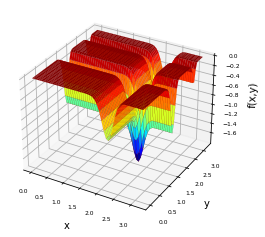

In [1]:
# michalewicz_graph.py

from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(0, 3.2, 50)    
Y = np.linspace(0, 3.2, 50)    
X, Y = np.meshgrid(X, Y)

# Michalewicz function
Z = -1 * ( (np.sin(X) * np.sin((1 * X**2) / np.pi)**20) + \
           (np.sin(Y) * np.sin((2 * Y**2) / np.pi)**20) )

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, \
  rstride=1, cstride=1, cmap=cm.jet, \
  edgecolor='darkred', linewidth=0.1)

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('y', fontsize=10)
ax.set_zlabel('f(x,y)', fontsize=10)
ax.tick_params(axis='both', which='major',
  labelsize=6)
    
plt.show()

Nelder Mead Function

In [2]:
def f(v): 
   return -1 * ( (np.sin(v[0]) * np.sin((1 * v[0]**2) / np.pi)**20) + \
            (np.sin(v[1]) * np.sin((2 * v[1]**2) / np.pi)**20) )
    

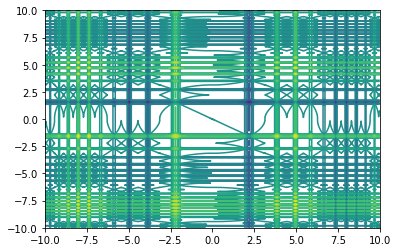

In [16]:
X, Y = np.meshgrid(np.linspace(-10, 10, 2000),
                   np.linspace(-10, 10, 2000))

Z = f([X,Y])

plt.contour(X, Y, Z, levels = 20)
plt.show()

In [4]:
def i_trg(x, y, c):
    x1 = x + c
    y1 = y
    x2 = x + c/2
    y2 = y + (c/2)*(3**(1/2))
    return list(zip(np.array([x,x1,x2]), np.array([y,y1,y2])))

In [5]:
def BGW(V, f):
    T = [(V[i], f(V[i])) for i in range(len(V)) ]
    return sorted(T, key=itemgetter(1))

    # alternatively, equivalent:
    #return sorted(T, key=lambda column: column[1]) 

In [6]:
def midpoint(o_trg, A=0, B=1):
    return ((o_trg[A][0][0] + o_trg[B][0][0])/2,
            (o_trg[A][0][1] + o_trg[B][0][1])/2)

def reflection(o_trg):
    M = midpoint(o_trg)
    W = o_trg[2][0]
    return (2*M[0] - W[0], 2*M[1] - W[1])

def expansion(o_trg):
    M = midpoint(o_trg)
    R = reflection(o_trg)
    return (2*R[0] - M[0], 2*R[1] - M[1])

def contraction(o_trg, f):
    M = midpoint(o_trg)
    R = reflection(o_trg)
    W = o_trg[2][0]
    insC = ((W[0] + M[0])/2, (W[1] + M[1])/2)
    outC = ((R[0] + M[0])/2, (R[1] + M[1])/2)
    return (insC, outC)

def shrink(o_trg, f):
    M, S  = midpoint(o_trg), midpoint(o_trg, A=0, B=2)
    return M, S

In [7]:
def nelder_mead(o_trg, f, iterations, plot=False):
    print("k \t {:^20}   \t {:^20}   \t {:^20}".format("Best point", "Good point", "Worst point"))
     
    for i in range(iterations):
        
        if (i == 0):     
            print("{} \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}"
                    .format(i+1, o_trg[0][0][0], o_trg[0][0][1], f(o_trg[0][0]),
                            o_trg[1][0][0], o_trg[1][0][1], f(o_trg[1][0]),
                            o_trg[2][0][0], o_trg[2][0][1], f(o_trg[2][0])))

            if plot:
                bgw = np.array([o_trg[i][0] for i in range(len(o_trg))])
                plt.clf()
                plt.contour(X, Y, Z, levels = 50)
                plt.plot((bgw[0,0], bgw[1,0]), (bgw[0,1], bgw[1,1]), '-b')
                plt.plot((bgw[2,0], bgw[1,0]), (bgw[2,1], bgw[1,1]), '-b')
                plt.plot((bgw[0,0], bgw[2,0]), (bgw[0,1], bgw[2,1]), '-b')
                plt.plot(bgw[0,0], bgw[0,1], '.r')
                plt.show(block=False)
                plt.pause(0.1)
        
        
        R = reflection(o_trg)
        G = o_trg[1][0]
        B = o_trg[0][0]
        
        if f(R) < f(G):
            # Case 1: reflection found a better point than Good point

            if f(B) < f(R):
                # Case 1a: reflected point is not better than Best point -> replace Worst with R and end this iteration
                
                o_trg = BGW([B, G, R], f)              
            else:
                # Case 1b: reflected point is better than Best point -> go even further (expansion)
                
                E = expansion(o_trg)
                if f(E) < f(R):
                    # Case 1ba: expanded point is better than reflected point -> replace Worst with E and end this iteration
                    o_trg = BGW([B, G, E], f)
                else:
                    # Case 1bb: expanded point is not better than reflected point -> replace Worst with R and end this iteration
                    o_trg = BGW([B, G, R], f)
        else:
            # Case 2: reflection found a worse point than Good point

            W = o_trg[2][0]
            if f(R) > f(W):
                # Case 2a: reflected point is worse than Worst point -> perform inside contraction
                C = contraction(o_trg, f)[0]
            else:
                # Case 2b: reflected point is not worse than Worst point -> perform outside contraction
                C = contraction(o_trg, f)[1]

            if f(C) < f(W):
                # Case 3a: contraction worked -> replace Worst with C and end this iteration
                o_trg = BGW([B, G, C], f)
            else:
                # Case 3b: contraction did not work -> shrink the triangle
                M, S = shrink(o_trg, f)
                o_trg = BGW([B, M, S], f)
         
        print("{} \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}"
              .format(i+1, o_trg[0][0][0], o_trg[0][0][1], f(o_trg[0][0]),
                      o_trg[1][0][0], o_trg[1][0][1], f(o_trg[1][0]),
                      o_trg[2][0][0], o_trg[2][0][1], f(o_trg[2][0])))
        
        if plot:
            bgw = np.array([o_trg[i][0] for i in range(len(o_trg))])
            plt.clf()
            plt.contour(X, Y, Z, levels = 50)
            plt.plot((bgw[0,0], bgw[1,0]), (bgw[0,1], bgw[1,1]), '-b')
            plt.plot((bgw[2,0], bgw[1,0]), (bgw[2,1], bgw[1,1]), '-b')
            plt.plot((bgw[0,0], bgw[2,0]), (bgw[0,1], bgw[2,1]), '-b')
            plt.plot(bgw[0,0], bgw[0,1], '.r')
            plt.show(block=False)
            plt.pause(0.1)
            
    plt.show()
                
    return o_trg

In [8]:
X, Y = np.meshgrid(np.linspace(-5, 5, 2000),
                   np.linspace(-5, 5, 2000))
v_func = np.vectorize(f)
Z = f([X,Y])

In [17]:
trg = i_trg(10,5,3)
trg

[(10.0, 5.0), (13.0, 5.0), (11.5, 7.598076211353316)]

In [18]:
nelder_mead(trg,f,20,plot=True)

k 	      Best point        	      Good point        	     Worst point     


IndexError: invalid index to scalar variable.